# Deep Active Learning for Fine-tuning Vision Transformers

> **_Google Colab Note:_** If the notebook fails to run after installing the needed packages, try to restart the runtime (Ctrl + M) under Runtime -> Restart session.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/scikit-activeml/scikit-activeml.github.io/blob/gh-pages/1.0/generated/tutorials_colab//01_deep_pool_al_with_skorch.ipynb)

**Notebook Dependencies**

Uncomment the following cell to install all dependencies for this tutorial.

In [ ]:
!pip install scikit-activeml[opt] torch torchvision tqdm pandas kornia transformers datasets

<hr style="border-style: solid; border-top: 1px solid; border-right: 0; border-bottom: 0; border-left: 0;">

In this brief tutorial, we show an example use-case of our package `skactiveml` with the Python package [skorch](https://skorch.readthedocs.io/en/stable/), which is a scikit-learn wrapper for Pytorch models. This way, we are able to implement and test deep learning models in combination with query strategies implemented in our framework.

In [2]:
# Comment in for speed up, if you have cuML installed.
# %load_ext cuml.accel
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import warnings

from copy import deepcopy
from datasets import load_dataset
from kornia import augmentation as K
from skactiveml.classifier import SkorchClassifier
from skactiveml.pool import (
    RandomSampling,
    TypiClust,
    CoreSet,
    UncertaintySampling,
    Badge,
    DropQuery,
    SubSamplingWrapper,
)
from skactiveml.utils import call_func
from skorch.callbacks import LRScheduler
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm


MISSING_LABEL = -1
RANDOM_STATE = 0
CACHE_PATH = ".cache"
os.makedirs(CACHE_PATH, exist_ok=True)
mlp.rcParams["figure.facecolor"] = "white"
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
device = "cuda" if torch.cuda.is_available() else "cpu"
warnings.filterwarnings("ignore")

cuML: Accelerator installed.


## Loading CIFAR10
We rely on `HuggingFace` to download the `CIFAR10` dataset containing 32 x 32px images of generic object classes.

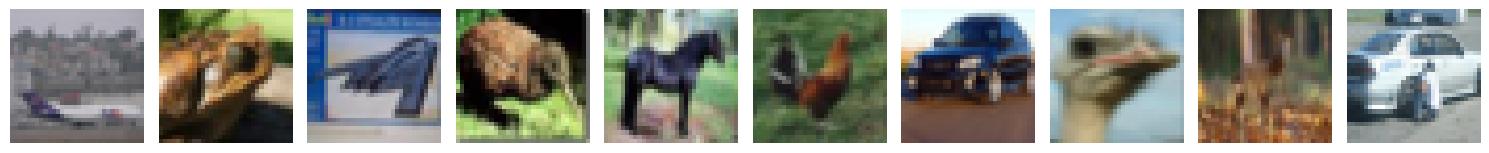

In [3]:
# Load CIFAR10 and convert to numpy.
ds = load_dataset("cifar10")
X_train = np.array(ds["train"]["img"], dtype=np.float32) / 255.0
X_test  = np.array(ds["test"]["img"], dtype=np.float32) / 255.0
X_train = np.transpose(X_train, (0, 3, 1, 2))
X_test  = np.transpose(X_test, (0, 3, 1, 2))
y_train_true = np.array(ds["train"]["label"], dtype=np.int64)
y_test_true  = np.array(ds["test"]["label"], dtype=np.int64)
classes = np.unique(y_train_true)
missing_label = -1

# Visualize 10 images.
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for j, ax in enumerate(axes):
    img = np.transpose(X_train[j], (1, 2, 0))  # (32, 32, 3)
    ax.imshow(img)
    ax.axis("off")
plt.tight_layout()
plt.show()

## Data Augmentation
Data augmentation is used to artificially generate data from existing data points. In case of image data, this can be done by rotating or scaling the image. Other basic transformations are:
* padding,
* vertical and horizontal flipping,
* translation,
* cropping,
* darkening, brightening, color modification,
* grayscaling,
* changing contrast,
* adding noise,
* random erasing.

For more information on data augmentation take a look at the [Data Augmentation Tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation) of [TensorFlow](https://www.tensorflow.org) or visit [Transforming And Augmenting Images](https://pytorch.org/vision/stable/transforms.html) on [PyTorch](https://pytorch.org). We define one transformation used during training and one used during evaluation.

In [4]:
# Transformers are designed to be used with a DINOv2 module.
train_transform = K.AugmentationSequential(
    K.Resize((256, 256)),
    K.RandomResizedCrop((224, 224), scale=(0.75, 1.0)),
    K.RandomHorizontalFlip(p=0.5),
    K.ColorJitter(0.2, 0.2, 0.2, 0.1, p=0.8),
    K.Normalize(
        mean=torch.tensor([0.485, 0.456, 0.406]),
        std=torch.tensor([0.229, 0.224, 0.225]),
    ),
    data_keys=["input"],
)

eval_transform = K.AugmentationSequential(
    K.Resize((256, 256)),
    K.CenterCrop((224, 224)),
    K.Normalize(
        mean=torch.tensor([0.485, 0.456, 0.406]),
        std=torch.tensor([0.229, 0.224, 0.225]),
    ),
    data_keys=["input"],
)

## DINOv2: A Vision Foundation Model
In the next step, we load DINOv2 ViT/S-14 as a popular vision foundation backbone as part of our classification module to be fine-tuned throughout the active learning cycles.

> **Note:** There is an interdependency between the
> - loss criterion (`nn.CrossEntropyLoss` in our example),
> - the outputted quantities (logits in our example),
> - and calling `predict_proba` to output actual probabilities (`predict_nonlinearity=nn.Softmax(dim=-1)` to normalize the logits).

In [5]:
# Define simple classifier with a DINOv2 module as backbone.
class DinoClassifier(nn.Module):
    def __init__(self, backbone, n_classes, train_tf=None, eval_tf=None):
        super().__init__()
        self.backbone = backbone
        self.head = nn.Linear(backbone.embed_dim, n_classes)
        self.train_tf = train_tf
        self.eval_tf = eval_tf

    def forward(self, x):
        if self.training and self.train_tf is not None:
            x = self.train_tf(x)
        if not self.training and self.eval_tf is not None:
            x = self.eval_tf(x)
        x_embed = self.backbone(x)
        logits = self.head(x_embed)
        return logits, x_embed


# Method to define block-wise learning rates and weight decays.
def dino_param_groups(backbone, base=0.01, decay=0.1, head_mult=1.0):
    L = len(getattr(backbone, "blocks", []))
    groups = [
        (
            "backbone.patch_embed.*",
            {"lr": base * decay ** (L + 1), "weight_decay": 0.0},
        ),
        (
            "backbone.pos_embed",
            {"lr": base * decay ** (L + 1), "weight_decay": 0.0},
        ),
        (
            "backbone.cls_token",
            {"lr": base * decay ** (L + 1), "weight_decay": 0.0},
        ),
    ]
    for i in range(L):
        wd = 0.0 if i >= L - 3 else 0.0  # lighter WD on last blocks
        groups.append(
            (
                f"backbone.blocks.{i}.*",
                {"lr": base * decay ** (L - i), "weight_decay": wd},
            )
        )
    groups += [
        ("backbone.norm.*", {"lr": base, "weight_decay": 0.0}),
        ("head.weight", {"lr": base * head_mult, "weight_decay": 0.0001}),
        ("head.bias", {"lr": base * head_mult, "weight_decay": 0.0}),
        ("*.bias", {"weight_decay": 0.0}),
        ("*.norm.weight", {"weight_decay": 0.0}),
    ]
    return groups


# Load backbone from torch hub. Replace, if other foundations model are to be used.
torch.hub.set_dir(CACHE_PATH)
vit_backbone = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

# Set optimizer parameters for the loaded backbone.
param_groups = dino_param_groups(vit_backbone)

clf_init = SkorchClassifier(
    module=DinoClassifier,
    criterion=nn.CrossEntropyLoss,
    forward_outputs={
        "proba": (0, nn.Softmax(dim=-1)), "emb": (1, None)
    },
    neural_net_param_dict={
        # Module-related parameters.
        "module__backbone": vit_backbone,
        "module__n_classes": len(classes),
        "module__train_tf": train_transform,
        "module__eval_tf": eval_transform,
        # Optimizer-related parameters.
        "max_epochs": 100,
        "batch_size": 128,
        "optimizer": torch.optim.RAdam,
        "optimizer__param_groups": param_groups,
        "callbacks": [
            ("lr_scheduler", LRScheduler(policy=CosineAnnealingLR, T_max=100))
        ],
        # General parameters.
        "verbose": 0,
        "device": device,
        "train_split": False,
        "iterator_train__shuffle": True,
        "torch_load_kwargs": {"weights_only": True},
    },
    classes=classes,
    missing_label=MISSING_LABEL,
)

Using cache found in .cache/facebookresearch_dinov2_main


## Active Classification
For our classifier, we evaluate six different query strategies regarding their sample selection. For this purpose, we start with zero labels and make 10 iterations of an active learning cycle with a batch size of 32.

> **Note:** The execution time strongly depends on whether a GPU or CPU will be used.

In [6]:
# Define setup.
n_cycles = 8
batch_size = 25
n_sub_set = 1000
qs_dict = {
    "RandomSampling": RandomSampling(
        random_state=RANDOM_STATE, missing_label=MISSING_LABEL
    ),
    "UncertaintySampling": UncertaintySampling(
        random_state=RANDOM_STATE,
        missing_label=MISSING_LABEL,
        method="margin_sampling",
    ),
    "Badge": Badge(
        clf_embedding_flag_name={"extra_outputs": "emb"},
        random_state=RANDOM_STATE,
        missing_label=MISSING_LABEL,
    ),
    "DropQuery": DropQuery(
        clf_embedding_flag_name={"extra_outputs": "emb"},
        random_state=RANDOM_STATE,
        missing_label=MISSING_LABEL,
    ),
    "TypiClust": TypiClust(
        random_state=RANDOM_STATE, missing_label=MISSING_LABEL
    ),
    "CoreSet": CoreSet(random_state=RANDOM_STATE, missing_label=MISSING_LABEL),
}
acc_dict = {key: np.zeros(n_cycles + 1) for key in qs_dict}

# Perform active learning with each query strategy.
for qs_name, qs in qs_dict.items():
    print(f"Execute active learning using {qs_name}.")
    # Set seed and copy classifier for consistent initialization.
    torch.manual_seed(RANDOM_STATE)
    torch.cuda.manual_seed(RANDOM_STATE)
    clf = deepcopy(clf_init)

    # Embedding function is not required by all query strategies.
    embed_samples_func = None
    if qs_name in ["TypiClust", "CoreSet"]:

        def embed_samples_func(X_to_embed):
            return clf.predict(X_to_embed, extra_outputs="emb")[1]

    # Wrapper to subsample unlabeled samples.
    qs = SubSamplingWrapper(
        query_strategy=qs,
        max_candidates=n_sub_set,
        exclude_non_subsample=True,
        embed_samples_func=embed_samples_func,
        random_state=RANDOM_STATE,
        missing_label=MISSING_LABEL,
    )

    # Create array of missing labels as initial labels.
    y = np.full_like(y_train_true, fill_value=MISSING_LABEL, dtype=np.int64)

    # Execute active learning cycle.
    for c in tqdm(range(n_cycles)):
        # Fit and evaluate clf.
        acc = clf.fit(X_train, y).score(X_test, y_test_true)
        acc_dict[qs_name][c] = acc

        # Select and update training data.
        query_idx = call_func(
            qs.query,
            X=X_train,
            y=y,
            clf=clf,
            fit_clf=False,
            batch_size=batch_size,
        )
        y[query_idx] = y_train_true[query_idx]

    # Fit and evaluate clf.
    clf.fit(X_train, y)
    acc_dict[qs_name][n_cycles] = clf.score(X_test, y_test_true)

Execute active learning using RandomSampling.


100%|██████████| 8/8 [05:40<00:00, 42.57s/it]


Execute active learning using UncertaintySampling.


100%|██████████| 8/8 [05:52<00:00, 44.09s/it]


Execute active learning using Badge.


100%|██████████| 8/8 [05:53<00:00, 44.16s/it]


Execute active learning using DropQuery.


100%|██████████| 8/8 [06:42<00:00, 50.28s/it]


Execute active learning using TypiClust.


100%|██████████| 8/8 [05:55<00:00, 44.47s/it]


Execute active learning using CoreSet.


100%|██████████| 8/8 [05:53<00:00, 44.23s/it]


## Visualize Results
In the following, we plot the obtained learning curves including the area under learning curve (AULC) scores per query strategy.

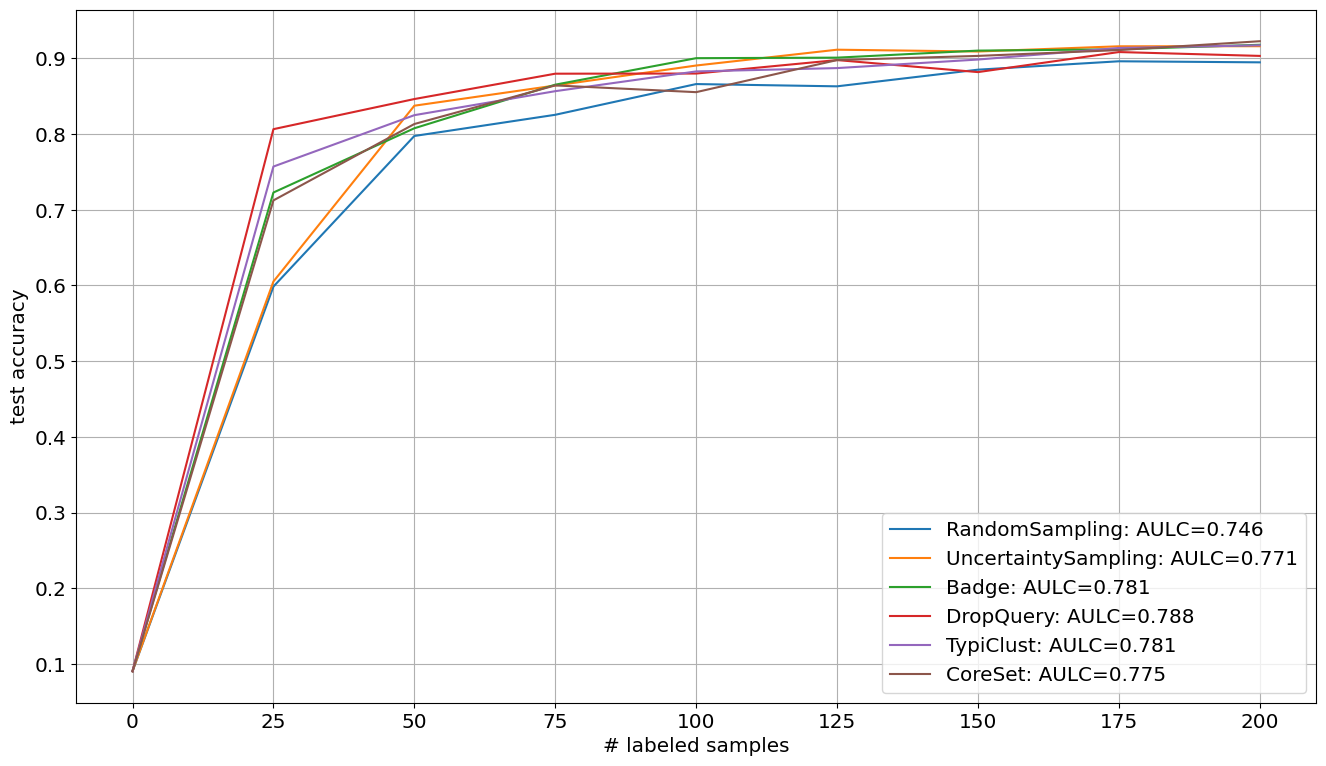

In [7]:
cycles = np.arange(n_cycles + 1, dtype=int)
plt.figure(figsize=(16, 9))
for qs_name, acc in acc_dict.items():
    plt.plot(
        cycles * batch_size,
        acc,
        label=f"{qs_name}: AULC={round(acc.mean(), 3)}",
    )
plt.xticks(cycles * batch_size, fontsize="x-large")
plt.yticks(np.arange(0.1, 1.0, 0.1), fontsize="x-large")
plt.grid()
plt.xlabel("# labeled samples", fontsize="x-large")
plt.ylabel("test accuracy", fontsize="x-large")
plt.legend(loc="lower right", fontsize="x-large")
plt.show()